# Mean Reversion TIme series and cross-section, with value as Price/moving average, returns as daily log returns, and Futures data 1 (12 commodities, of energy, metals,  from 2004 to late 2019)

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import DataReader
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
# Price data
data_px = pd.read_excel("FuturesSeries.xlsx", sheet_name= 'Data')


In [7]:

cross_list_total_px= ['BRENT','NATGAS','GOLD','COPPER','WHEAT','COCOA','WTI','NYHarb','SILVER','PLATINUM','SOYBEAN','CORN']
# Create asset class data and fill NAs
cross_data_total_px=data_px[cross_list_total_px]
initial = (cross_data_total_px[:3959]).dropna()


In [19]:
cross_data_total_px.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4171 entries, 2004-01-02 to 2019-12-27
Data columns (total 12 columns):
BRENT       4116 non-null float64
NATGAS      3959 non-null float64
GOLD        3960 non-null float64
COPPER      4017 non-null float64
WHEAT       3964 non-null float64
COCOA       3956 non-null float64
WTI         4025 non-null float64
NYHarb      3959 non-null float64
SILVER      4025 non-null float64
PLATINUM    4024 non-null float64
SOYBEAN     4029 non-null float64
CORN        4029 non-null float64
dtypes: float64(12)
memory usage: 423.6 KB


In [20]:
initial.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3727 entries, 2004-01-05 to 2019-03-06
Data columns (total 12 columns):
BRENT       3727 non-null float64
NATGAS      3727 non-null float64
GOLD        3727 non-null float64
COPPER      3727 non-null float64
WHEAT       3727 non-null float64
COCOA       3727 non-null float64
WTI         3727 non-null float64
NYHarb      3727 non-null float64
SILVER      3727 non-null float64
PLATINUM    3727 non-null float64
SOYBEAN     3727 non-null float64
CORN        3727 non-null float64
dtypes: float64(12)
memory usage: 538.5 KB


In [8]:
from fredapi import Fred
fred = Fred(api_key='7c161acab6738b3fe57d68ce58877860')
CPI = pd.DataFrame(fred.get_series('CPIAUCSL'))
CPI.columns = ['index']

In [9]:

# create index multiplier
CPI['CPI_Multiplier'] = CPI['index'].iloc[-1] / CPI['index']


In [10]:
CPI = CPI.loc[(initial.iloc[0].name).replace(day=1) :]
CPI.head(4)

,index,CPI_Multiplier
2004-01-01,186.3,1.384611
2004-02-01,186.7,1.381644
2004-03-01,187.1,1.378691
2004-04-01,187.4,1.376483


In [11]:
s3 = initial.join(CPI, how='outer')
s3=s3.drop('index',axis=1)
s3['CPI_Multiplier'] = s3['CPI_Multiplier'].fillna(method='ffill')
columns = list(initial.columns) + list(['CPI_Multiplier'])
columns
s3.columns = columns
infl_adjusted = s3[columns].multiply(s3['CPI_Multiplier'], axis="index")
infl_adjusted = infl_adjusted.drop(['CPI_Multiplier'],axis=1)
infl_adjusted = infl_adjusted.dropna()
infl_adjusted.head(5)


,BRENT,NATGAS,GOLD,COPPER,WHEAT,COCOA,WTI,NYHarb,SILVER,PLATINUM,SOYBEAN,CORN
2004-01-05,42.770629,9.452738,588.182686,3301.950707,551.767421,2040.916382,46.772154,134.085714,8.630279,1166.534635,1103.188689,350.306543
2004-01-06,42.673706,9.805814,585.967309,3251.758564,546.228977,2146.146806,46.661385,135.331864,8.745202,1178.165366,1102.496384,348.229627
2004-01-07,42.590630,9.523353,584.721159,3244.835510,547.613588,2273.531004,46.550617,133.767254,8.655202,1169.857701,1090.381039,346.152711
2004-01-08,43.033705,9.822429,587.628842,3337.258284,545.536672,2230.608068,47.049076,136.259553,8.669048,1185.919187,1098.688704,348.575780
2004-01-09,43.435242,10.089659,590.951908,3355.258225,533.767480,2313.684718,47.505998,139.790311,8.979201,1183.842271,1093.842566,347.537322


In [17]:
infl_adjusted.head(3)

,BRENT,NATGAS,GOLD,COPPER,WHEAT,COCOA,WTI,NYHarb,SILVER,PLATINUM,SOYBEAN,CORN
2004-01-05,42.770629,9.452738,588.182686,3301.950707,551.767421,2040.916382,46.772154,134.085714,8.630279,1166.534635,1103.188689,350.306543
2004-01-06,42.673706,9.805814,585.967309,3251.758564,546.228977,2146.146806,46.661385,135.331864,8.745202,1178.165366,1102.496384,348.229627
2004-01-07,42.590630,9.523353,584.721159,3244.835510,547.613588,2273.531004,46.550617,133.767254,8.655202,1169.857701,1090.381039,346.152711


In [12]:
def returns(px):
    returns = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    returns.columns = px.columns
    for x in returns.columns:
        returns[x] = np.log(px[x] / px[x].shift(1))
    return returns
    

In [67]:
def time_series_signal_long_and_longshort(px,y):
    ma_df = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    ma_df = px.rolling(window=252*y).mean()
    ma_df.columns = px.columns
    signal_df = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    signal_df.columns = px.columns
    for x in signal_df:
        signal_df[x] = np.where(px[x]<=ma_df[x],1,-1)
        dig = pd.DataFrame(signal_df[x])
        dig.index = px.index
        dig = dig.plot()
        dig = dig.get_figure()
        dig.savefig(str(x)+'.jpg')
        
    signal_df.index = px.index
    signal_df = signal.dropna()
    
    signal_df_long = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    signal_df_long.columns = px.columns
    for x in signal_df_long:
        signal_df_long[x] = np.where(px[x]<=ma_df[x],1,0)
    signal_df_long.index = px.index
    return_long_short = signal_df.shift(1) * returns(px)
    return_long = signal_df_long.shift(1) * returns(px)
    
    print("TIME SERIES")
    print("LONG_SHORT Returns")       
    print(return_long_short.sum())
    print("TOTAL RETURN  ", return_long_short.sum().sum())
    print("")
    print("LONG ONLY Returns")
    print(return_long.sum())
    print("TOTAL RETURN  ", return_long.sum().sum())


    bench = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    bench.columns = px.columns
    
    for x in bench.columns:
        bench["Market " +x] = returns(px)[x]
        bench["Long-Short Model "+x] = return_long_short[x] 
        bench["Long Only Model "+x] = return_long[x] 
        fig = bench[["Market " +x,"Long-Short Model "+x,"Long Only Model "+x ]].cumsum().plot(grid=True,figsize=(8,5))
        fig = fig.get_figure()
        #fig.savefig(str(x)+'.jpg')

    
    return return_long_short, return_long, signal_df

TIME SERIES
LONG_SHORT Returns
BRENT       0.561460
NATGAS      2.176433
GOLD       -0.736396
COPPER      1.143285
WHEAT       1.287475
COCOA       0.526093
WTI         1.463547
NYHarb      0.876557
SILVER     -1.637371
PLATINUM   -0.419820
SOYBEAN    -0.404223
CORN       -0.245826
dtype: float64
TOTAL RETURN   4.59121305278222

LONG ONLY Returns
BRENT       0.505090
NATGAS      0.494677
GOLD        0.031085
COPPER      0.916397
WHEAT       0.538664
COCOA       0.318457
WTI         0.831300
NYHarb      0.649766
SILVER     -0.534664
PLATINUM   -0.373705
SOYBEAN    -0.302087
CORN       -0.098270
dtype: float64
TOTAL RETURN   2.9767096537524598


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


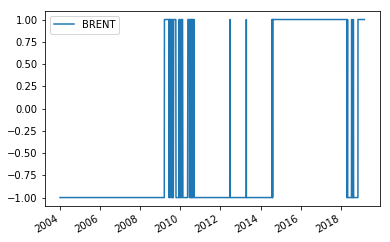

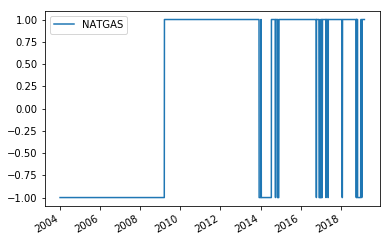

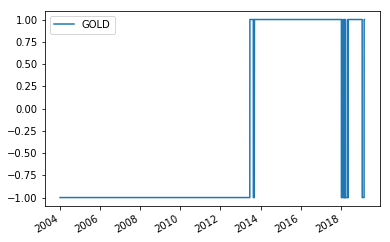

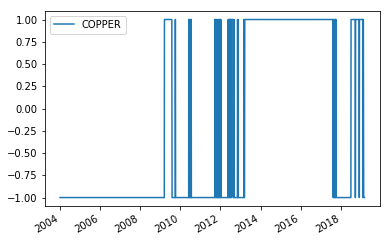

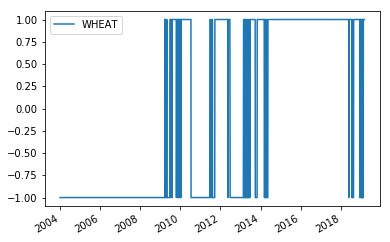

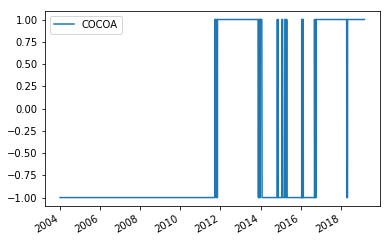

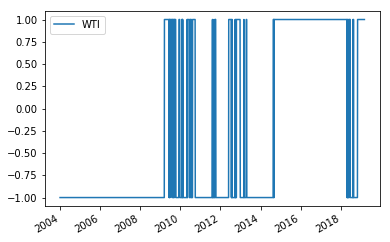

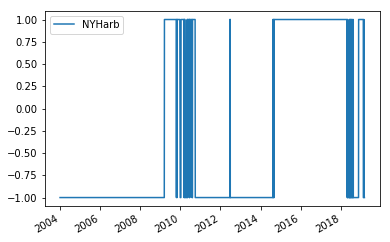

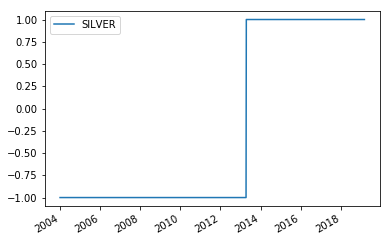

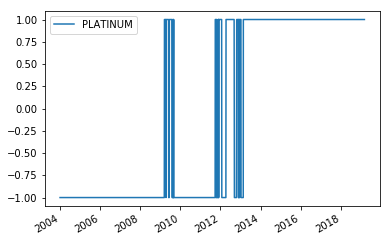

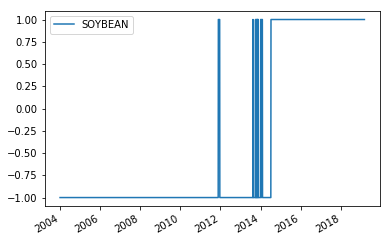

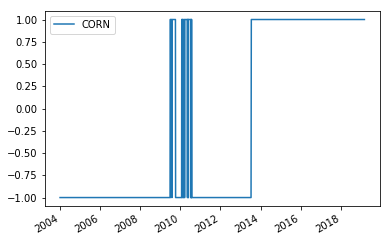

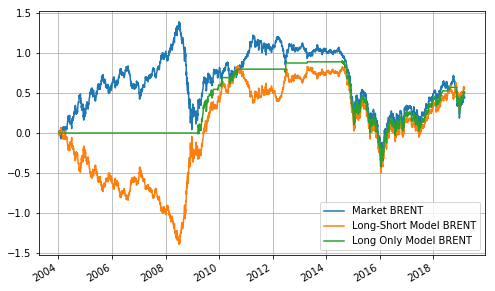

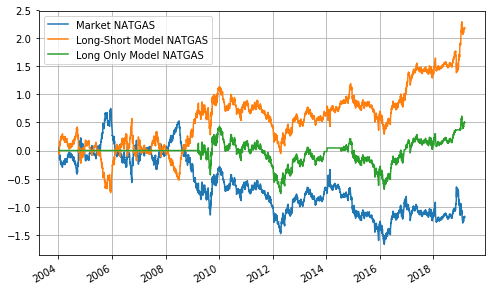

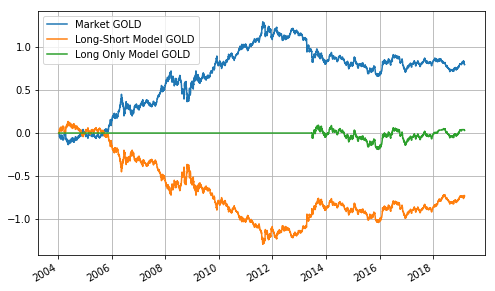

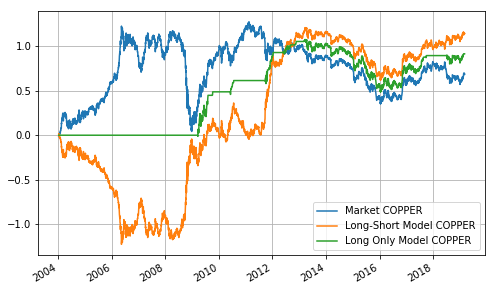

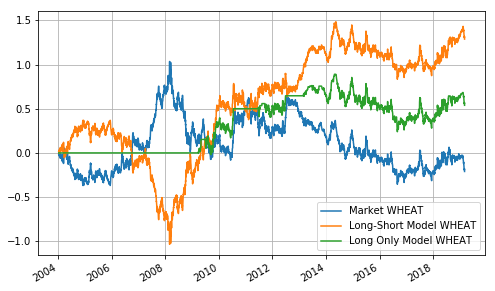

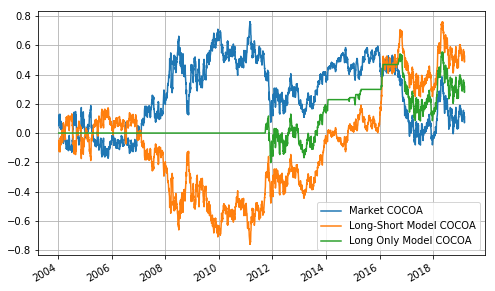

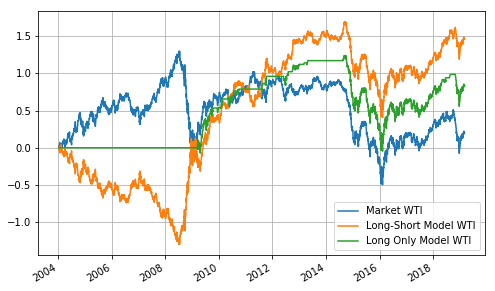

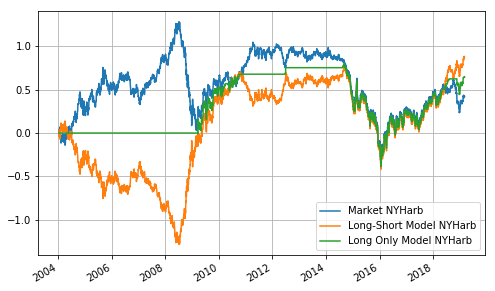

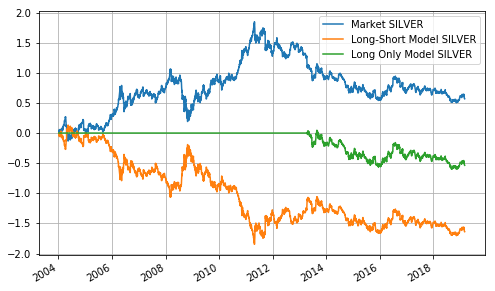

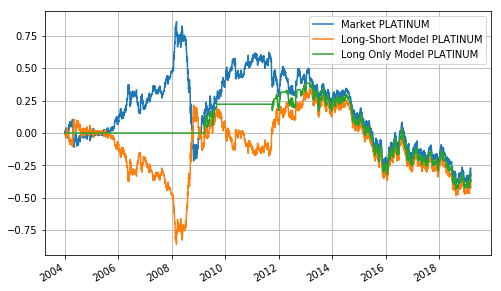

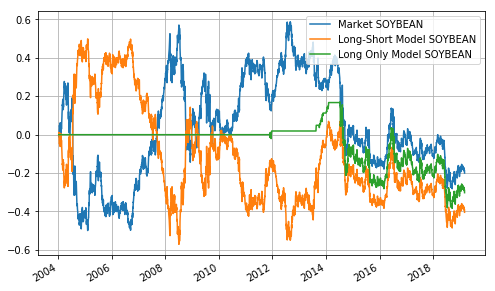

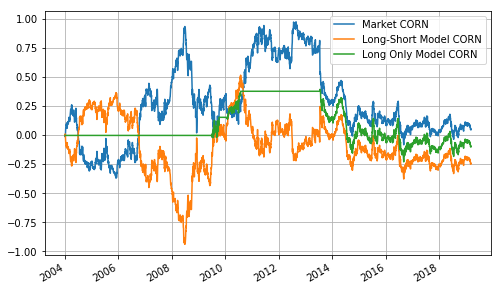

In [73]:
(long_short, long, signal) = time_series_signal_long_and_longshort(infl_adjusted,5)

In [74]:
def cross_section__signal_long_and_longshort(px,y, ):
    cross_ma = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    cross_ma = px / px.rolling(window=252*y).mean()
    cross_ma = cross_ma.dropna()
    cross_ma.columns = px.columns
    ranks = cross_ma.rank(axis=1, ascending=False)
    ranks.index = cross_ma.index
    
    signal_df_long_short = pd.DataFrame(index=ranks.index,columns = ranks.columns )
    for x in ranks.index:
        signal_df_long_short.loc[x] = np.where(ranks.loc[x]<int(len(px.columns)/3)+1,-1,0)
        signal_df_long_short.loc[x] = np.where(ranks.loc[x]>int(len(px.columns)/3)*2,1, signal_df_long_short.loc[x])
    signal_df_long_short.index = cross_ma.index
    
    signal_df_long = pd.DataFrame(index=ranks.index,columns = ranks.columns )
    for x in ranks.index:
        signal_df_long.loc[x] = np.where(ranks.loc[x]>int(len(px.columns)/3)*2,1, 0)
    signal_df_long.index = cross_ma.index
    
    return_long_short = signal_df_long_short.shift(1) * returns(px)
    return_long = signal_df_long.shift(1) * returns(px)
    print("CROSS SECTION")
    print("LONG_SHORT Returns")       
    print(return_long_short.sum())
    print("TOTAL RETURN  ", return_long_short.sum().sum())
    print("")
    print("LONG ONLY Returns")
    print(return_long.sum())
    print("TOTAL RETURN  ", return_long.sum().sum())


    bench = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    bench.columns = px.columns
    for x in bench.columns:
        bench["Market " +x] = returns(px)[x]
        bench["Long-Short Model "+x] = return_long_short[x] 
        bench["Long Only Model "+x] = return_long[x] 
        fig = bench[["Market " +x,"Long-Short Model "+x,"Long Only Model "+x ]].cumsum().plot(grid=True,figsize=(8,5))
        fig = fig.get_figure()
 
    
    return return_long_short, return_long

CROSS SECTION
LONG_SHORT Returns
BRENT       1.241410
NATGAS      1.983379
GOLD       -0.414170
COPPER      0.801810
WHEAT       1.601149
COCOA       0.925895
WTI         1.292230
NYHarb      1.575190
SILVER     -0.530029
PLATINUM    0.373522
SOYBEAN     0.277383
CORN       -0.039153
dtype: float64
TOTAL RETURN   9.088617728808751

LONG ONLY Returns
BRENT       0.781936
NATGAS      0.394547
GOLD       -0.071270
COPPER      0.448220
WHEAT       0.589934
COCOA       0.417330
WTI         0.719332
NYHarb      0.637414
SILVER     -0.390534
PLATINUM    0.259519
SOYBEAN    -0.074939
CORN       -0.011573
dtype: float64
TOTAL RETURN   3.699916481860643


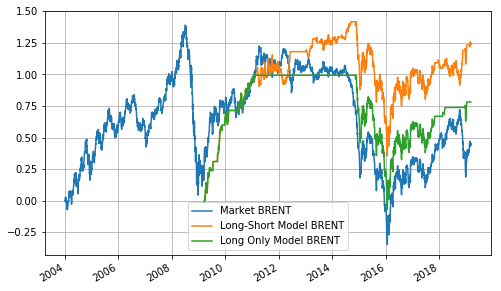

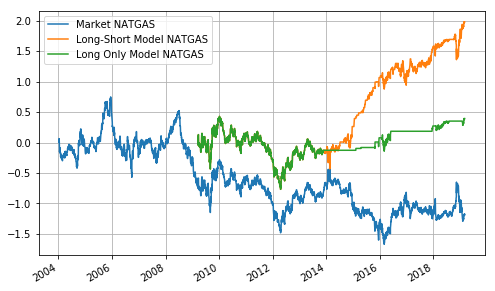

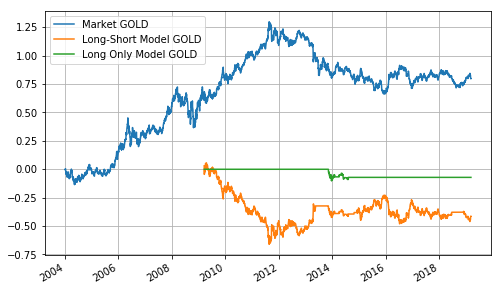

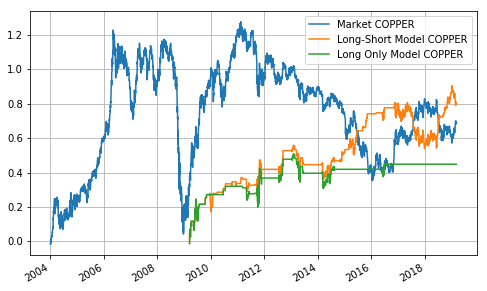

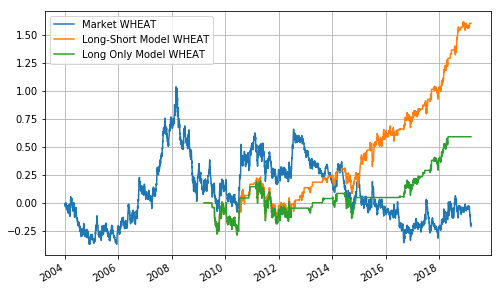

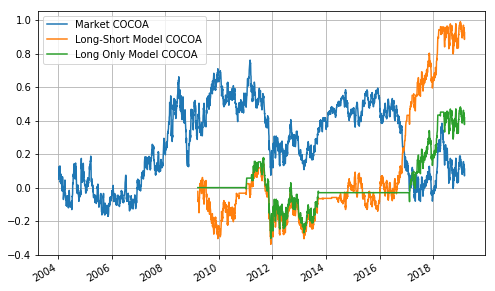

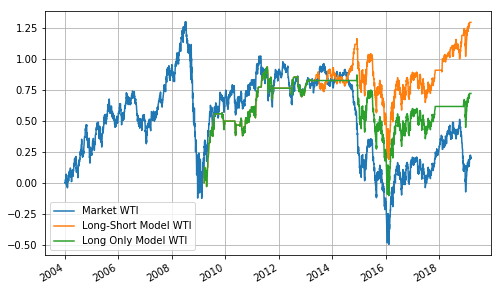

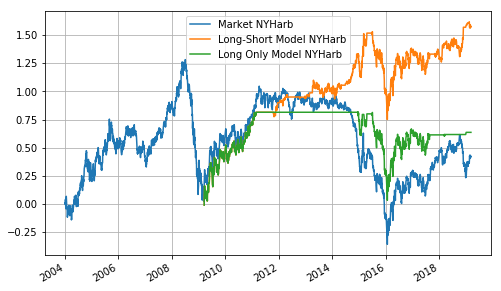

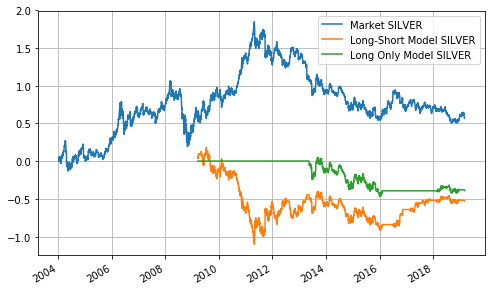

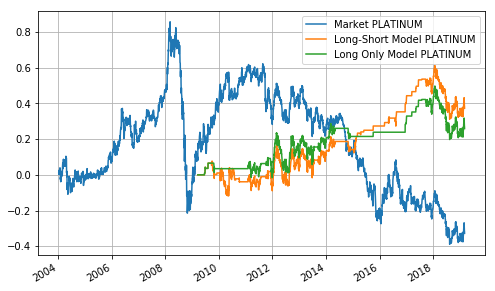

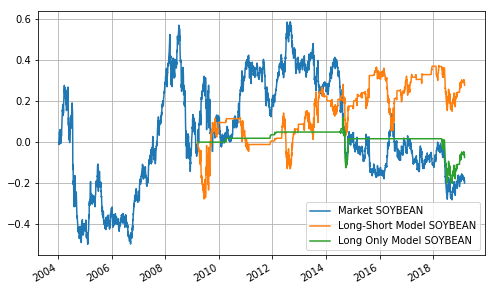

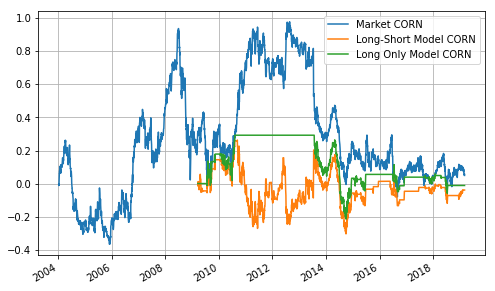

In [75]:
(long_short, long) = cross_section__signal_long_and_longshort(infl_adjusted,5)

In [ ]:
#by removing ['NICKEL', 'COFFEE', 'PALLADIUM', 'COTTON'], total return was improved

In [117]:
#y=months

def heat_cross_section__signal_long_and_longshort(px,y, f):
    cross_ma = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    cross_ma = px / px.rolling(window=21*y).mean()
    cross_ma = cross_ma.dropna()
    cross_ma.columns = px.columns
    ranks = cross_ma.rank(axis=1, ascending=False)
    ranks.index = cross_ma.index
    
    signal_df_long_short = pd.DataFrame(index=ranks.index,columns = ranks.columns )
    for x in ranks.index:
        signal_df_long_short.loc[x] = np.where(ranks.loc[x]<int(len(px.columns)*f),-1,0)
        signal_df_long_short.loc[x] = np.where(ranks.loc[x]>int(len(px.columns)*(1-f)),1, signal_df_long_short.loc[x])
    signal_df_long_short.index = cross_ma.index
    

    
    return_long_short = signal_df_long_short.shift(1) * returns(px)


    r = return_long_short.sum().sum()


    return r

In [111]:
(r, signal) = heat_cross_section__signal_long_and_longshort(infl_adjusted,60,0.5)

In [112]:
r

10.369635672392514

In [118]:
import numpy as np
from collections import defaultdict
months = range(12, 60, 6) 
weight = np.arange(0.1, 1, 0.1)
dd = defaultdict(dict)
for y in months:
    for f in weight:
        dd[y][f] = heat_cross_section__signal_long_and_longshort(infl_adjusted,y, f)
        ddf = pd.DataFrame(dd)
        ddf.index.name = 'Signal Weight' 
        ddf.columns.name = 'Lookback Period in Months'

In [119]:
import matplotlib.pyplot as plt
def heatmap(df, cmap=plt.cm.hot):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values, cmap=cmap, interpolation='nearest') 
    ax.set_xlabel(df.columns.name) 
    ax.set_xticks(np.arange(len(df.columns))) 
    ax.set_xticklabels(list(df.columns)) 
    ax.set_ylabel(df.index.name) 
    ax.set_yticks(np.arange(len(df.index))) 
    ax.set_yticklabels(list(df.index))
    plt.colorbar(axim)

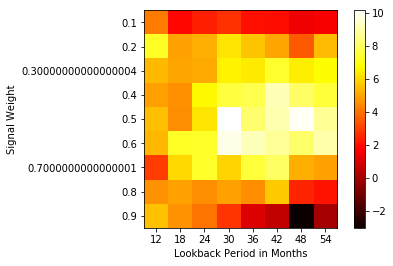

In [120]:
heatmap(ddf)